# Visually Comparing Climate Models



---
### Summary

In this notebook, I will be comparing three climate reanalysis models:

* NCEP-DOE Reanalysis 2: Surface
* ERA5
* CMIP5

I will be looking at the following variables:

* Mean Sea Level Pressure (CMIP5, ERA5, NCEP)
* Surface Pressure (ERA5, NCEP)

I will be trying to user RBIG in order to assess how similar these models are. I'll be looking at the following IT measures. If these climate models are that similar, then they should exhibit similar IT measures.

---
### Preprocessing Steps

**Regridded Spatially**

* The ERA5 had the coarsest spatial resolution (2.5 x 2.5). 
* I regridded the NCEP from (0.25 x 0.25) to (2.5 x 2.5).
* I regridded the CMIP5 from (2 x 2.5) to (2.5 x 2.5).

**Temporal Resolution**

* ERA5 and NCEP go from 1980-2019
* CMIP5 goes from 2006-2018
* For comparing ERA5 vs CMIP5 and NCEP vs CMIPF, I found the same time components


---
### Measures

I'm measuring the following:

* Entropy - expected uncertainty
* Total Correlation - amount of redundant information between features
* Mutual Information - amount of information shared between variables


---
### Data

**Inputs**

I'm taking each year as is. Each spatial location is a sample and each year is a feature. My inputs are:

$$X \in \mathbb{R}^{\text{spatial } \times \text{ month}}$$

**Outputs**

All my information theory measures are in nats. They are scalars.

---
### Hypothesis

Simple: The ERA5 and the NCEP model should be more similar than the CMIP5 model compared to each of them. 

---
## Data - Climate Models

In [3]:
!ls /home/emmanuel/projects/2020_rbig_rs/notebooks/climate/../../

LICENSE    data		    environment_dev.yml  notebooks   reports   src
README.md  environment.yml  environment_gpu.yml  references  setup.py


In [25]:
import os, sys
cwd = os.getcwd()
source_path = f"{cwd}/../../"
sys.path.insert(0, f'{source_path}')

# Import RBIG Helper
from src.models.train_models import run_rbig_models

# ESDC tools
sys.path.insert(0, f'/home/emmanuel/code/py_esdc')
# from esdc.preprocessing import normalize_temporal
from pathlib import Path


import cdsapi
from zipfile import ZipFile
import pandas as pd
import xarray as xr
from tqdm import tqdm
from sklearn import preprocessing

# Visualization Tools
from src.data.climate.loader import ResultsLoader
# from src.visualization.climate import PlotResults
from src.visualization.climate.amip import plot_diff, plot_individual, plot_individual_diff

import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.style.use(['seaborn-poster', 'fivethirtyeight'])

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment I - Local

In [26]:
data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/interim/amip/local/individual/"

def get_results_files(base_model: str)-> pd.DataFrame:
    
    path = Path(data_path)
    
    if base_model == 'ncep':
        filename_pattern = 'ncep_*_v1.csv'
        
    elif base_model == 'era5':
        filename_pattern = 'era5_*_v1.csv'
        
    else:
        raise ValueError('Unrecognized base model:', base_model)
    
    df_from_each_file = [pd.read_csv(f, index_col=0) for f in path.rglob(filename_pattern)]
    results_df   = pd.concat(df_from_each_file, ignore_index=True)
    return results_df

In [27]:
def post_processing(df: pd.DataFrame)-> pd.DataFrame:
    
    # divide by the spatial resolution
    df['h_base'] = df['h_base'] / (df['spatial'] ** 2)
    df['h_cmip'] = df['h_cmip'] / (df['spatial'] ** 2)
    
    return df

### NCEP - Individual IT Measures

In [28]:
data_path = f"/home/emmanuel/projects/2020_rbig_rs/data/climate/interim/amip/local/individual/"
fig_path = f"/home/emmanuel/projects/2020_rbig_rs/reports/figures/climate/amip/local/individual/"

In [29]:
# extract results
results_df = get_results_files('ncep')

# post processing

results_df = post_processing(results_df)

In [30]:
results_df.head()

,base,base_time,cmip,cmip_time,h_base,h_cmip,spatial,subsample,t_base,t_cmip,tc_base,tc_cmip,trial,variable
0,ncep,1979-02-01,access1_0,1979-01-16 12:00:00,1.154962,1.111020,1.0,50000.0,1.387569,1.424181,0.0,0.0,0.0,psl
1,ncep,1979-03-01,access1_0,1979-02-15 00:00:00,1.110414,1.186688,1.0,50000.0,1.447177,1.410388,0.0,0.0,0.0,psl
2,ncep,1979-04-01,access1_0,1979-03-16 12:00:00,1.008000,1.207379,1.0,50000.0,1.400458,1.420720,0.0,0.0,0.0,psl
3,ncep,1979-05-01,access1_0,1979-04-16 00:00:00,1.057721,1.166715,1.0,50000.0,1.430815,1.446585,0.0,0.0,0.0,psl
4,ncep,1979-06-01,access1_0,1979-05-16 12:00:00,1.117835,1.000079,1.0,50000.0,1.373620,1.421061,0.0,0.0,0.0,psl


We want to extract the different CMIP models. The other parameters are constant for now.

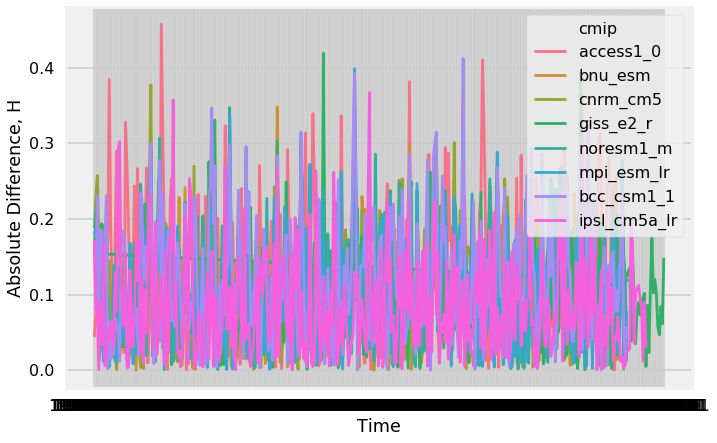

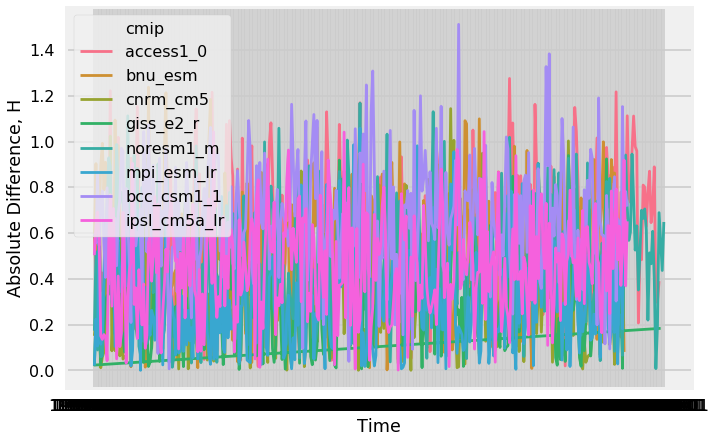

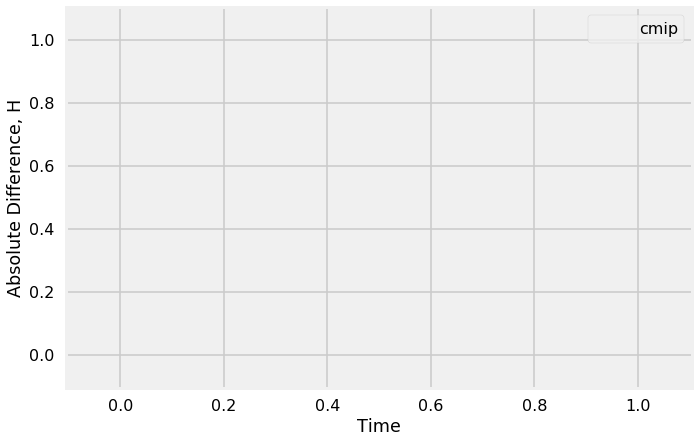

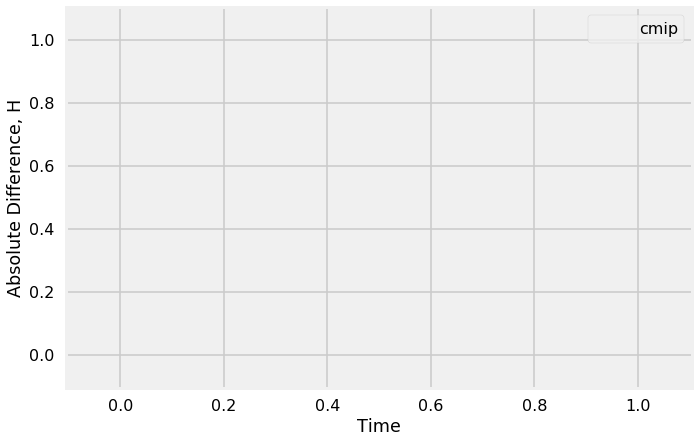

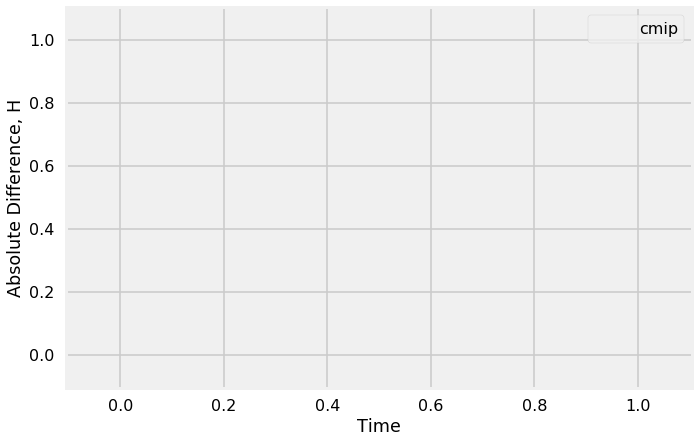

In [31]:
sample_spatial = 1.0
for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_diff(results_df, ispatial)

### ERA5 - Individual IT Measures

In [32]:
# extract results
results_df = get_results_files('era5')

# post processing

results_df = post_processing(results_df)

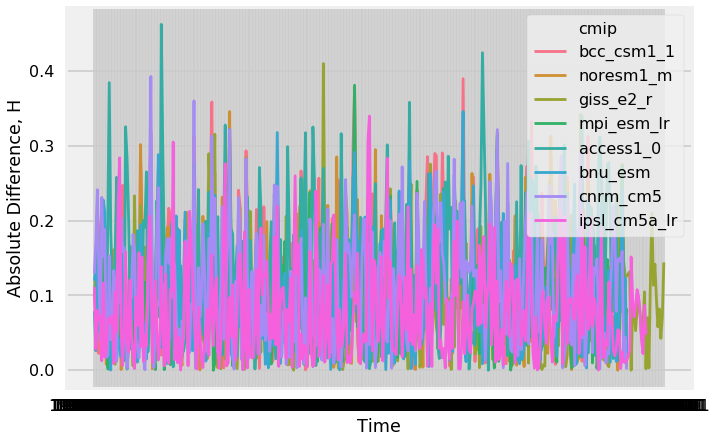

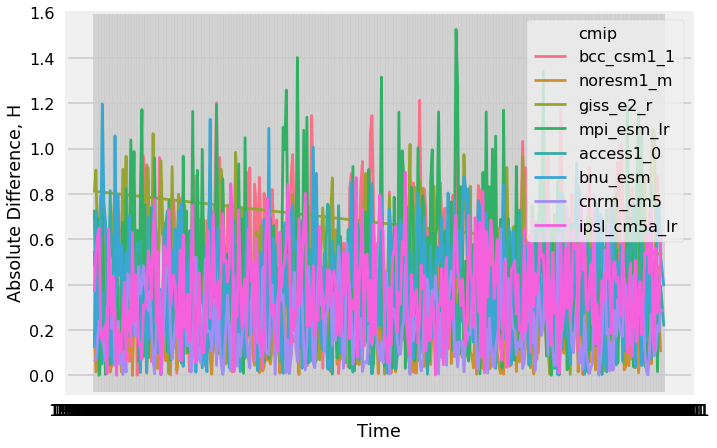

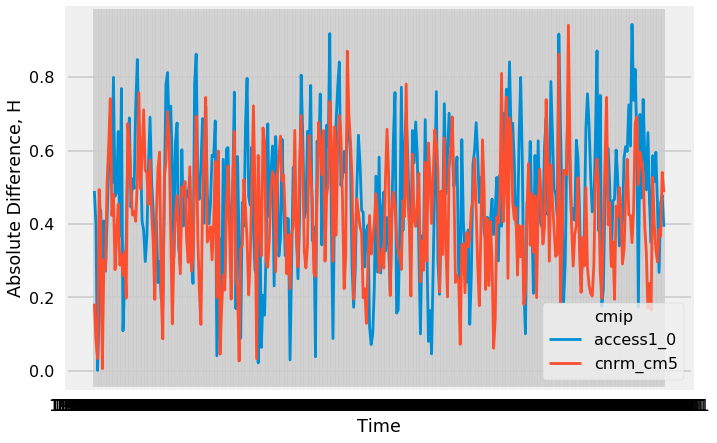

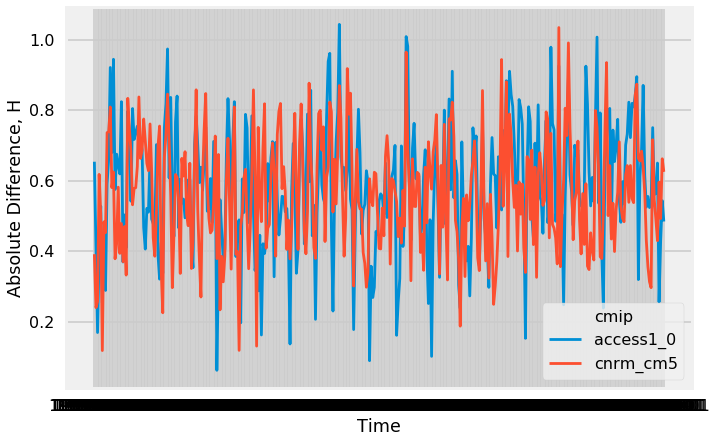

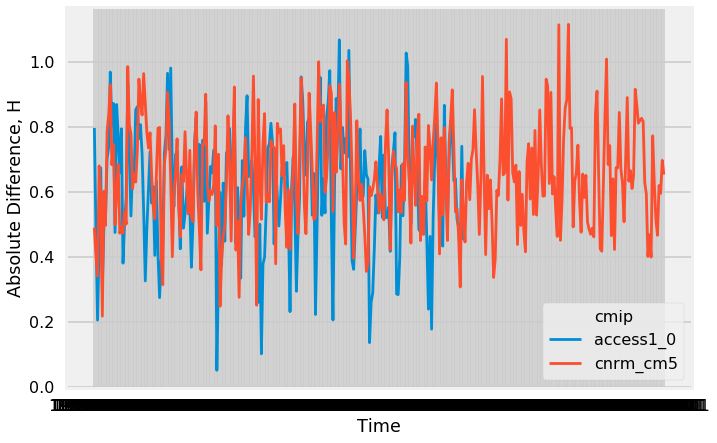

In [33]:
sample_spatial = 1.0
for ispatial in [1.0, 2.0, 3.0, 4.0, 5.0]:
    
    plot_diff(results_df, ispatial)

## Results

### Mean Sea Level Pressure

#### CMIP5 vs ERA5 vs NCEP

In [6]:
variables = [
    'mslp_era_cmip', 
    'mslp_ncep_cmip'
]

filenames = [f"{results_path}{variable}.csv" for variable in variables]

results = ResultsLoader(filenames).load_dataframes()

# initializer plotter
plotter = PlotResults(results)

In [7]:
plotter.results = plotter.results[plotter.results['year'] < 2019]

#### Entropy

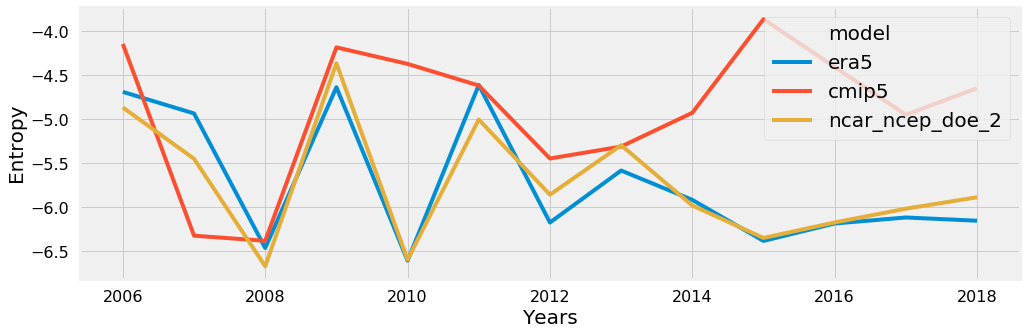

In [8]:
ent1_fig, ent1_ax = plotter.plot_entropy()

#### Total Correlation

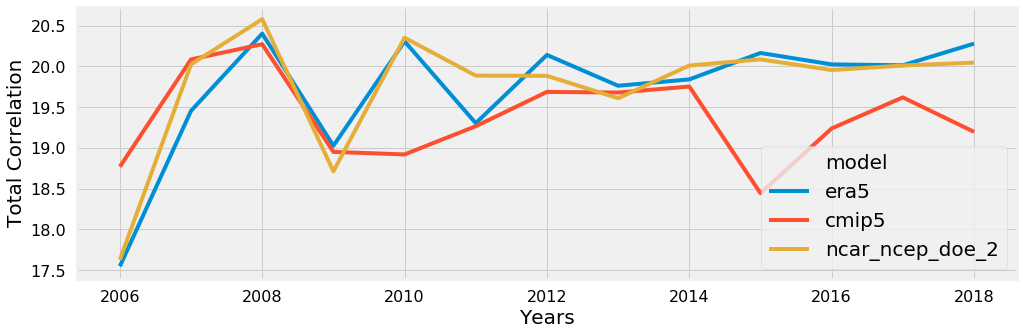

In [9]:
tc1_fig, tc1_ax = plotter.plot_total_correlation()

#### Mutual Information 

This is the MI between CMIP5 and the two models (ERA5 and NCEP)

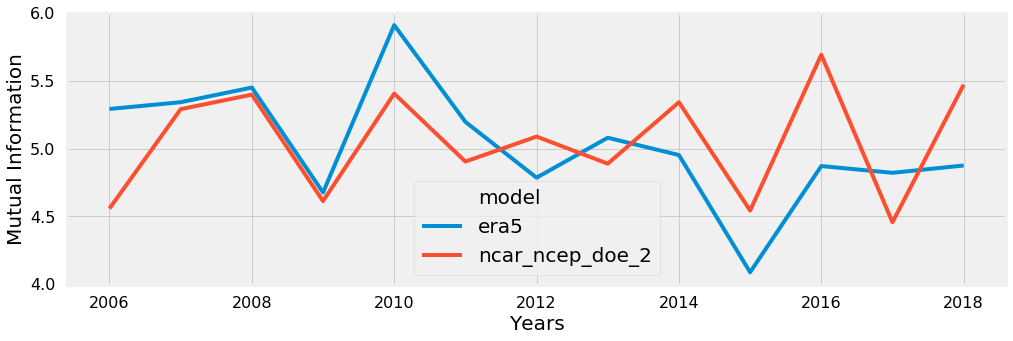

In [10]:
mi1_fig, mi1_ax = plotter.plot_mutual_information(('model', ['cmip5']))

## NCEP vs ERA5

### Mean Sea Level Pressure

In [18]:
variables = [
    'mslp_ncep_era'
]

filenames = [f"{results_path}{variable}.csv" for variable in variables]

results = ResultsLoader(filenames).load_dataframes()

# initializer plotter
plotter = PlotResults(results)

In [19]:
plotter.results = plotter.results[plotter.results['year'] < 2017]  

#### Entropy

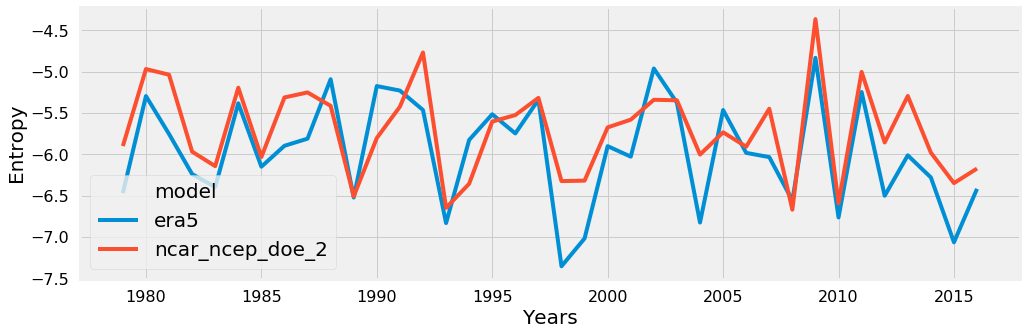

In [20]:
plotter.plot_entropy();

#### Total Correlation

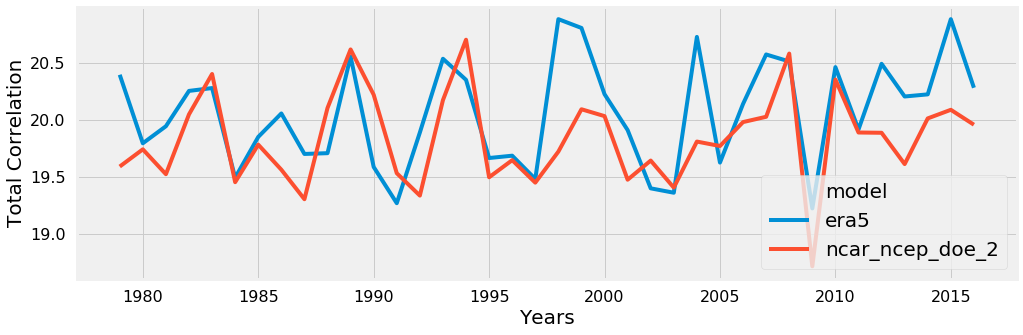

In [21]:
plotter.plot_total_correlation();

#### Mutual Information

The MI between ERA5 and the NCAR_NCEP_DOE_2 model.

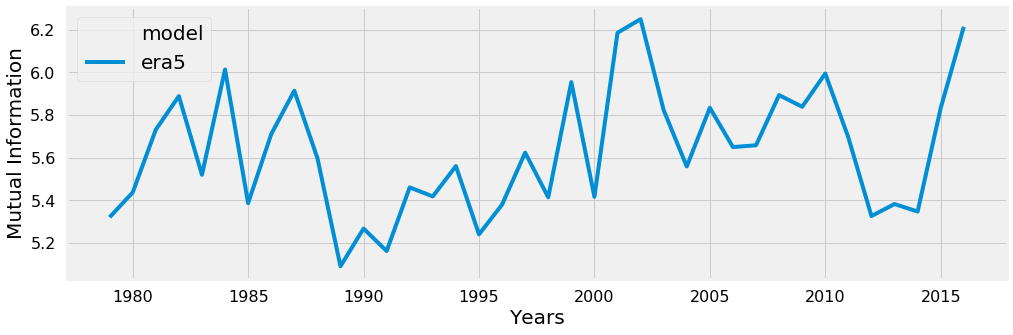

In [22]:
plotter.plot_mutual_information(omit_models=('model', ['ncar_ncep_doe_2']));

### Surface Pressure

In [23]:
variables = [
    'sp_ncep_era'
]

filenames = [f"{results_path}{variable}.csv" for variable in variables]

results = ResultsLoader(filenames).load_dataframes()

# initializer plotter
plotter = PlotResults(results)

In [24]:
plotter.results = plotter.results[plotter.results['year'] < 2018]  

#### Entropy

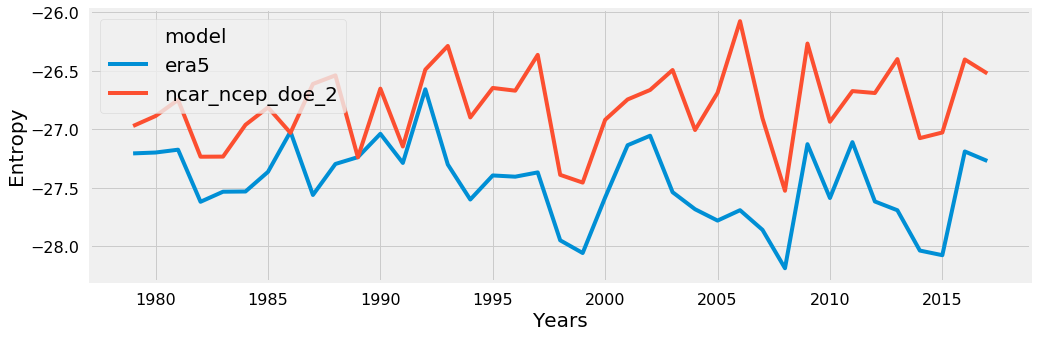

In [25]:
plotter.plot_entropy();

#### Total Correlation

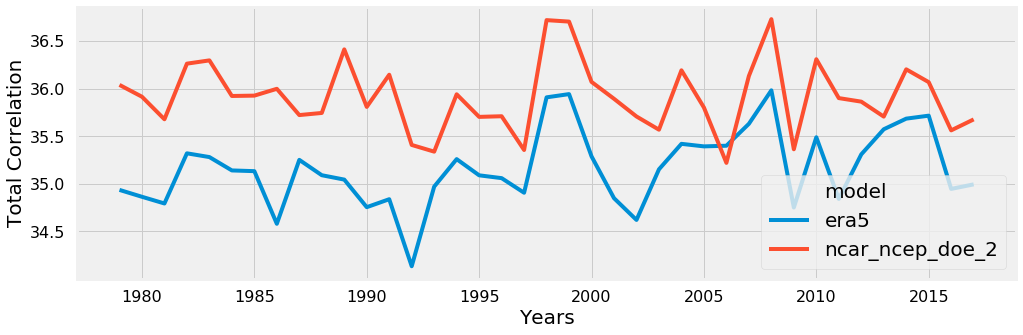

In [26]:
plotter.plot_total_correlation();

#### Mutual Information

The MI between ERA5 and NCEP.

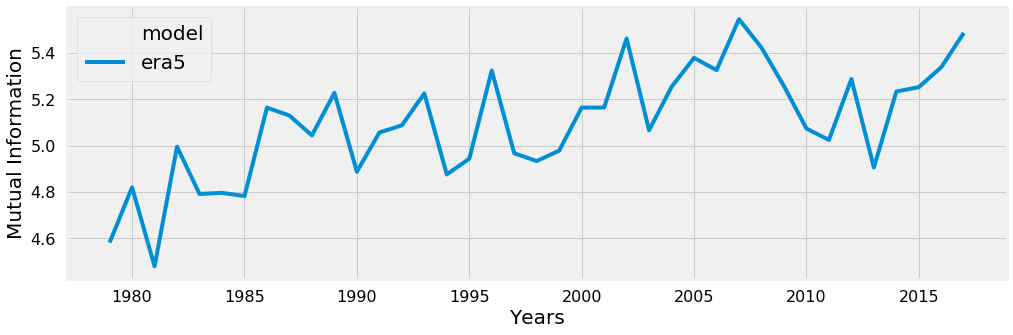

In [27]:
plotter.plot_mutual_information(omit_models=('model', ['ncar_ncep_doe_2']));